# [**Pièges courants dans l'interprétation des coefficients des modèles linéaires**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/4_inspection/plot_linear_model_coefficient_interpretation.ipynb)<br/>([*Common pitfalls in the interpretation of coefficients of linear models*](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html))

Dans les modèles linéaires, la valeur cible est modélisée comme une combinaison linéaire des caractéristiques (voir la section [**Modèle linéaires** (1.1)](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/1_1_linear_model.ipynb) du Guide de l'utilisateur pour une description des modèles linéaires disponibles dans scikit-learn). Les coefficients de plusieurs modèles linéaires représentent la relation entre une caractéristique donnée, $X_i$ et la cible, $y$, en supposant que toutes les autres caractéristiques restent constantes ([wkpd:**dépendance conditionnelle**](https://en.wikipedia.org/wiki/Conditional_dependence)). Ceci est différent de tracer $X_i$ par rapport à $y$ et d'ajuster d'une relation linéaire : dans ce cas, toutes les valeurs possibles des autres caractéristiques sont prises en compte dans l'estimation (dépendance marginale).

Cet exemple fournira quelques conseils pour interpréter le coefficient dans les modèles linéaires, en soulignant les problèmes qui surviennent lorsque le modèle linéaire n'est pas approprié pour décrire l'ensemble de données ou lorsque les caractéristiques sont corrélées.

Nous utiliserons les données de la [“Current Population Survey”](https://www.openml.org/search?type=data&sort=runs&id=534&status=active) de 1985 pour prédire le salaire en fonction de diverses caractéristiques telles que l'expérience, l'âge ou l'éducation.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## L'ensemble de données : les salaires

Nous récupérons les données d'[OpenML](https://www.openml.org/). Notez que définir le paramètre `as_frame` sur `True` récupérera les données en tant que dataframe pandas.

In [2]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

Ensuite, nous identifions les caractéristiques `X` et les cibles `y` : la colonne `WAGE` est notre variable cible (c'est-à-dire la variable que nous voulons prédire).

In [3]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Notez que l'ensemble de données contient des variables catégorielles et numériques. Nous devrons en tenir compte lors du prétraitement de l'ensemble de données par la suite.

In [4]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


Notre cible de prédiction : le salaire (*Wage*). Les salaires sont décrits comme un nombre à virgule flottante en dollars par heure.

In [5]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

Nous divisons l'échantillon en un ensemble de données d'entraînement et de test. Seul l'ensemble de données d'entraînement sera utilisé dans l'analyse exploratoire qui suit. C'est une façon d'imiter une situation réelle où les prédictions sont effectuées sur une cible inconnue, et nous ne voulons pas que notre analyse et nos décisions soient biaisées par notre connaissance des données de test.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Tout d'abord, examinons les distributions des variables et les relations par paires entre elles. Seules les variables numériques seront utilisées. Dans le graphique suivant, chaque point représente un échantillon.

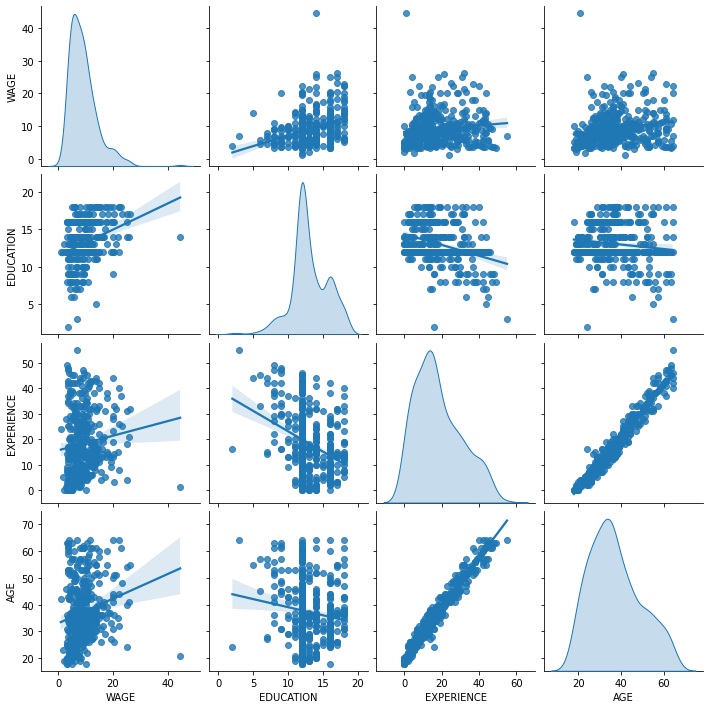

In [7]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

Un examen attentif de la distribution WAGE révèle qu'elle a une longue queue. Pour cette raison, nous devrions prendre son logarithme pour le transformer approximativement en une distribution normale (les modèles linéaires tels que l'arête ou le lasso fonctionnent mieux pour une distribution normale d'erreur).

Le SALAIRE augmente lorsque l'ÉDUCATION augmente. Notez que la dépendance entre SALAIRE et ÉDUCATION représentée ici est une dépendance marginale, c'est-à-dire qu'elle décrit le comportement d'une variable spécifique sans maintenir les autres fixes.

De plus, l'EXPÉRIENCE et l'ÂGE sont fortement corrélés linéairement.

## Le pipeline d'apprentissage automatique

Pour concevoir notre pipeline d'apprentissage automatique, nous vérifions d'abord manuellement le type de données que nous traitons :

In [8]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   AGE         534 non-null    float64 
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), float64(3)
memory usage: 17.2 KB


Comme vu précédemment, le jeu de données contient des colonnes avec différents types de données et nous devons appliquer un prétraitement spécifique pour chaque type de données. En particulier, les variables catégorielles ne peuvent pas être incluses dans le modèle linéaire si elles ne sont pas d'abord codées sous forme d'entiers. De plus, pour éviter que les caractéristiques catégorielles soient traitées comme des valeurs ordonnées, nous devons les encoder à chaud. Notre pré-processeur va

* encoder à chaud (*one-hot-encode*) (c'est-à-dire générer une colonne par catégorie) les colonnes catégorielles, uniquement pour les variables catégorielles non binaires ;
* en première approche (nous verrons plus tard comment la normalisation des valeurs numériques affectera notre discussion), gardez les valeurs numériques telles qu'elles sont.

In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

Pour décrire l'ensemble de données comme un modèle linéaire, nous utilisons un régresseur d'arête avec une très petite régularisation et pour modéliser le logarithme du WAGE.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

## Traitement du jeu de données

On commence par ajuster le modèle.

In [11]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

Ensuite, nous vérifions les performances du modèle calculé en traçant ses prédictions sur l'ensemble de test et en calculant, par exemple, l'erreur absolue médiane du modèle.

In [12]:
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

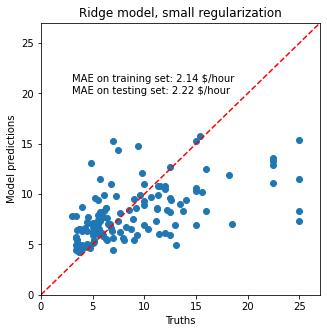

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Ridge model, small regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

Le modèle appris est loin d'être un bon modèle faisant des prédictions précises : c'est évident quand on regarde le graphique ci-dessus, où les bonnes prédictions devraient se situer sur la ligne rouge.

Dans la section suivante, nous interpréterons les coefficients du modèle. Ce faisant, nous devons garder à l'esprit que toute conclusion que nous tirons concerne le modèle que nous construisons, plutôt que le véritable processus de génération (du monde réel) des données.

## Interprétation des coefficients : l'échelle compte

Tout d'abord, nous pouvons jeter un œil aux valeurs des coefficients du régresseur que nous avons ajusté.

In [14]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013550
RACE_Other,-0.009106
RACE_White,0.022563
OCCUPATION_Clerical,0.000055
OCCUPATION_Management,0.090538
OCCUPATION_Other,-0.025091
OCCUPATION_Professional,0.071974
OCCUPATION_Sales,-0.046626
OCCUPATION_Service,-0.091043
SECTOR_Construction,-0.000139


Le coefficient AGE est exprimé en « dollars/heure par années de vie » tandis qu'EDUCATION est exprimé en “dollars/heure par années d'études”. Cette représentation des coefficients a l'avantage de clarifier les prédictions pratiques du modèle : une augmentation d'1 année en AGE signifie une diminution de 0.030867 dollars/heure, tandis qu'une augmentation d'1 année en EDUCATION signifie une augmentation de 0.054699 dollars/heure. Par contre, les variables catégorielles (comme UNION ou SEX) sont des nombres adimensionnels prenant soit la valeur 0 soit 1. Leurs coefficients sont exprimés en dollars/heure. Ensuite, nous ne pouvons pas comparer l'amplitude de différents coefficients puisque les caractéristiques ont des échelles naturelles différentes, et donc des plages de valeurs, en raison de leur unité de mesure différente. Ceci est plus visible si nous traçons les coefficients.

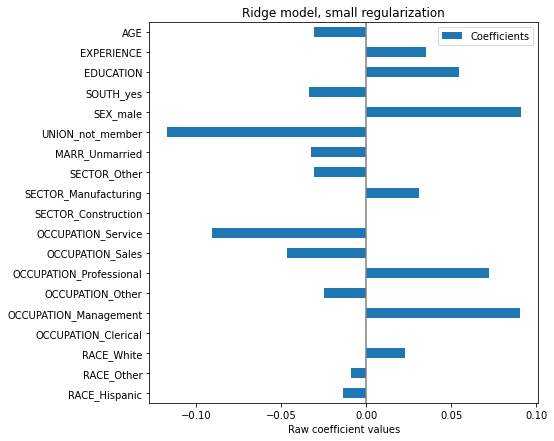

In [15]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

En effet, d'après le graphique ci-dessus, le facteur le plus important dans la détermination du SALAIRE semble être la variable UNION, même si notre intuition pourrait nous dire que des variables comme EXPÉRIENCE devraient avoir plus d'impact.

Regarder le graphique des coefficients pour évaluer l'importance des caractéristiques peut être trompeur car certaines d'entre elles varient à petite échelle, tandis que d'autres, comme AGE, varient beaucoup plus, sur plusieurs décennies.

Ceci est visible si nous comparons les écarts-types de différentes caractéristiques.

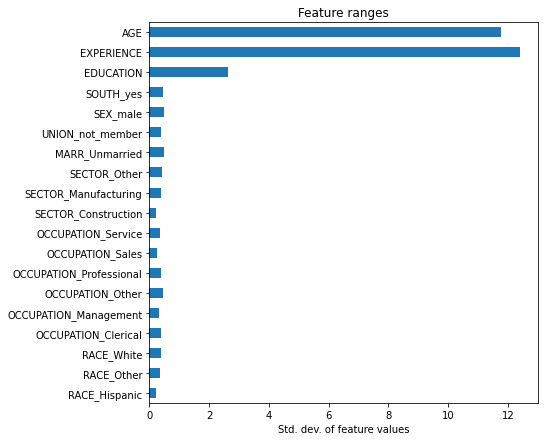

In [16]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

Multiplier les coefficients par l'écart type de l'élément connexe réduirait tous les coefficients à la même unité de mesure. Comme nous le verrons par la suite cela revient à normaliser les variables numériques à leur écart-type, comme

$$y = \sum \beta_i \times X_i = \sum (\beta_i \times \sigma_i)(X_i/\sigma_i)$$

De cette façon, nous soulignons que plus la variance d'une caractéristique est grande, plus le poids du coefficient correspondant sur la sortie est grand, toutes choses étant égales par ailleurs.

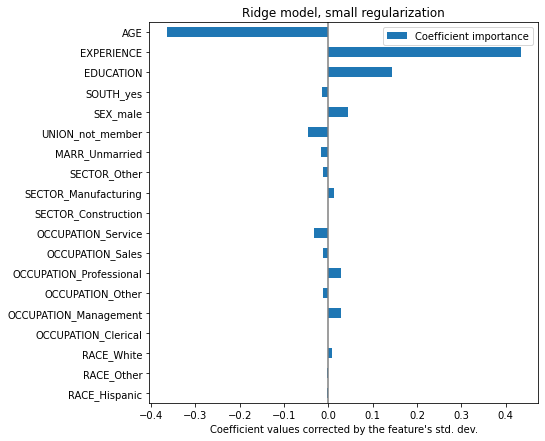

In [17]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Maintenant que les coefficients ont été mis à l'échelle, nous pouvons les comparer en toute sécurité.

**Avertissement** Pourquoi le graphique ci-dessus suggère-t-il qu'une augmentation de l'âge entraîne une diminution du salaire ? Pourquoi le pairplot initial dit le contraire ?

Le graphique ci-dessus nous renseigne sur les dépendances entre une caractéristique spécifique et la cible lorsque toutes les autres caractéristiques demeurent constantes, c'est-à-dire les dépendances conditionnelles. Une augmentation de l'AGE induira une diminution du SALAIRE lorsque toutes les autres caractéristiques restent constantes. Au contraire, une augmentation d'EXPERIENCE induira une augmentation du SALAIRE lorsque toutes les autres caractéristiques restent constantes. Aussi, l'AGE, l'EXPÉRIENCE et l'EDUCATION sont les trois variables qui influencent le plus le modèle.

## Vérification de la variabilité des coefficients

Nous pouvons vérifier la variabilité des coefficients par validation croisée : c'est une forme de perturbation des données (liée au rééchantillonnage).

Si les coefficients varient considérablement lors de la modification de l'ensemble de données d'entrée, leur robustesse n'est pas garantie et ils doivent probablement être interprétés avec prudence.

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

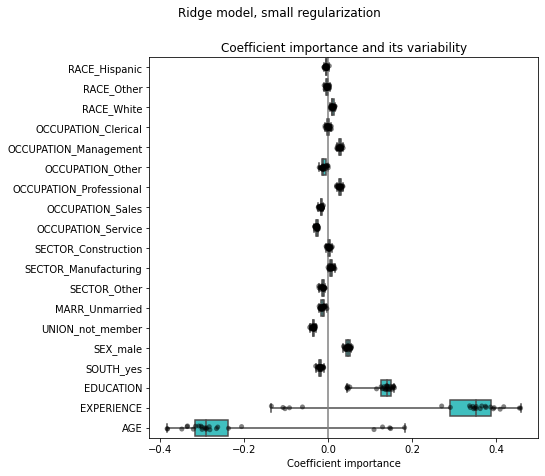

In [19]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

## Le problème des variables corrélées

Les coefficients AGE et EXPERIENCE sont affectés par une forte variabilité qui pourrait être due à la colinéarité entre les 2 caractéristiques : comme AGE et EXPERIENCE varient ensemble dans les données, leur effet est difficile à distinguer.

Pour vérifier cette interprétation, nous traçons la variabilité des coefficients AGE et EXPERIENCE.

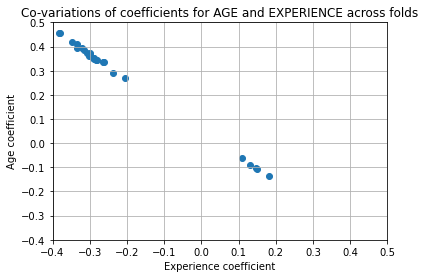

In [20]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

Deux régions sont peuplées : lorsque le coefficient d'EXPERIENCE est positif celui d'AGE est négatif et vice-versa.

Pour aller plus loin, nous supprimons l'une des 2 caractéristiques et évaluons l'impact sur la stabilité du modèle.

In [21]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_
        * est[:-1].transform(X.drop(columns=column_to_drop).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names[:-1],
)

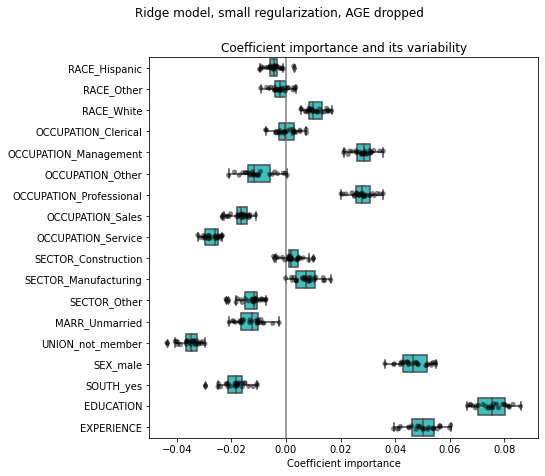

In [22]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model, small regularization, AGE dropped")
plt.subplots_adjust(left=0.3)

L'estimation du coefficient EXPERIENCE montre maintenant une variabilité très réduite. EXPERIENCE reste important pour tous les modèles entraînés lors de la validation croisée.

## Prétraitement des variables numériques

Comme indiqué ci-dessus (voir ["Le pipeline d'apprentissage automatique"](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#the-pipeline)), nous pourrions également choisir de mettre à l'échelle les valeurs numériques avant d'entraîner le modèle. Cela peut être utile lorsque nous appliquons une quantité similaire de régularisation à tous dans la réduction de crête. Le préprocesseur est redéfini afin de soustraire la moyenne et les variables d'échelle à la variance unitaire.

In [23]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

Le modèle demeure inchangé.

In [24]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

Encore une fois, nous vérifions les performances du modèle calculé en utilisant, par exemple, l'erreur absolue médiane du modèle et le coefficient $R^2$.

In [25]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

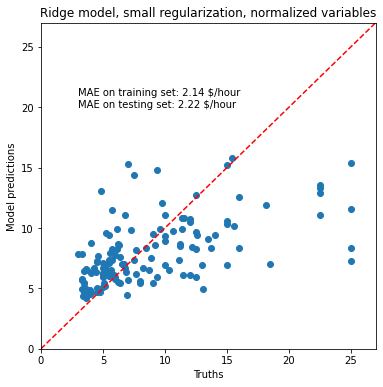

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, small regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

Pour l'analyse des coefficients, la mise à l'échelle n'est pas nécessaire cette fois car elle a été effectuée lors de l'étape de prétraitement

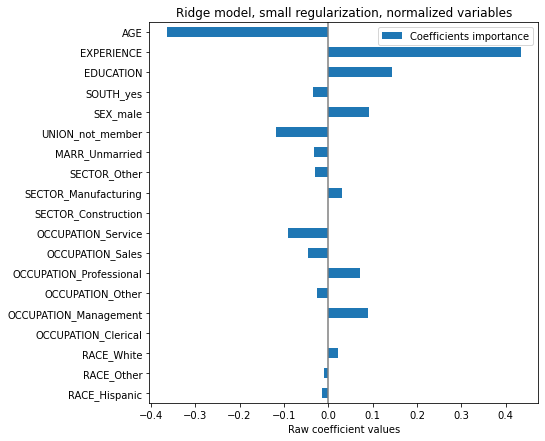

In [27]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Nous inspectons maintenant les coefficients sur plusieurs plis de validation croisée. Comme dans l'exemple ci-dessus, nous n'avons pas besoin de mettre à l'échelle les coefficients par l'écart type des valeurs des caractéristiques puisque cette mise à l'échelle a déjà été effectuée dans l'étape de prétraitement du pipeline.

In [28]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

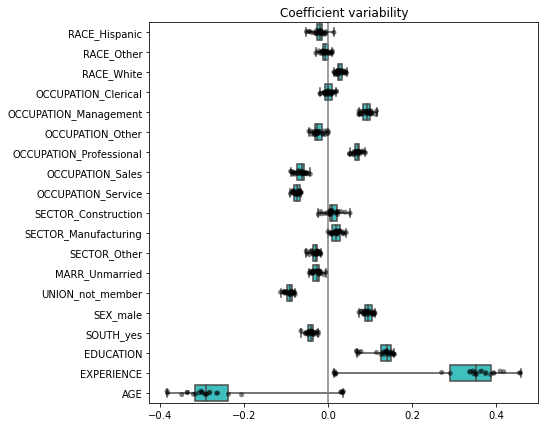

In [29]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

Le résultat est assez similaire au cas non normalisé.

## Modèles linéaires avec régularisation

Dans la pratique de l'apprentissage automatique, la régression ridge est plus souvent utilisée avec une régularisation non négligeable.

Ci-dessus, nous avons limité cette régularisation à un très petit montant. La régularisation améliore le conditionnement du problème et réduit la variance des estimations. [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) applique une validation croisée afin de déterminer quelle valeur du paramètre de régularisation (`alpha`) est la mieux adaptée à la prédiction.

In [30]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

On vérifie d'abord quelle valeur de $\alpha$ a été sélectionnée.

In [31]:
model[-1].regressor_.alpha_

10.0

Ensuite, nous vérifions la qualité des prédictions.

In [32]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

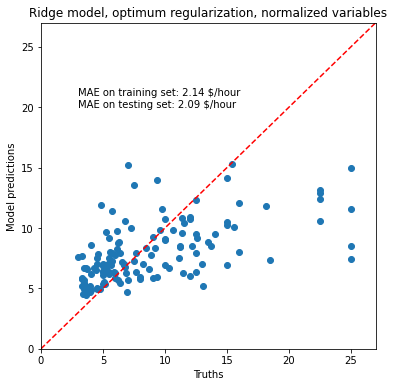

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, optimum regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

La capacité à reproduire les données du modèle régularisé est similaire à celle du modèle non régularisé.

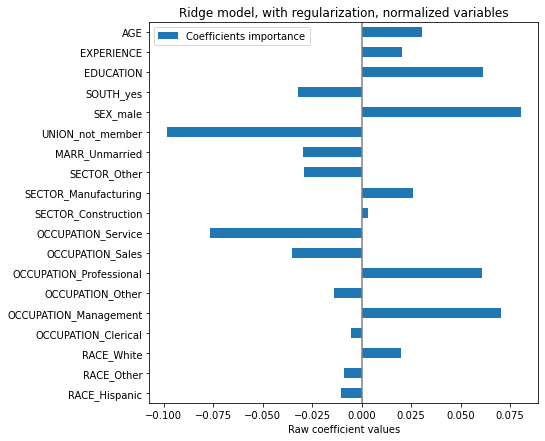

In [34]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Les coefficients sont sensiblement différents. Les coefficients AGE et EXPERIENCE sont tous deux positifs mais ils ont maintenant moins d'influence sur la prédiction.

La régularisation réduit l'influence des variables corrélées sur le modèle car le poids est partagé entre les deux variables prédictives, de sorte qu'aucune des deux n'aurait de poids forts.

En revanche, les poids obtenus avec la régularisation sont plus stables (voir la section Guide de l'utilisateur [**Régression et classification Ridge** (1.1.2)](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/1_1_linear_model.ipynb#ridge-regression)). Cette stabilité accrue est visible sur le graphique, obtenu à partir de perturbations de données, dans une validation croisée. Ce tracé peut être comparé au précédent.

In [35]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

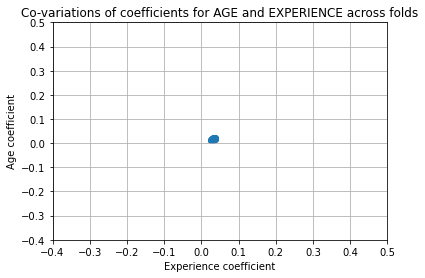

In [36]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

## Modèles linéaires à coefficients creux

Une autre possibilité de prendre en compte des variables corrélées dans l'ensemble de données consiste à estimer des coefficients creux. D'une certaine manière, nous l'avons déjà fait manuellement lorsque nous avons supprimé la colonne AGE dans une précédente estimation de crête.

Les modèles Lasso (voir la section [**Lasso** (1.1.3)](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/1_1_linear_model.ipynb#lasso) du Guide de l'utilisateur) estiment les coefficients parcimonieux. [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) applique une validation croisée afin de déterminer quelle valeur du paramètre de régularisation (`alpha`) est la mieux adaptée à l'estimation du modèle.

In [37]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

On vérifie d'abord quelle valeur de $\alpha$ a été sélectionnée.

In [38]:
model[-1].regressor_.alpha_

0.001

Ensuite, nous vérifions la qualité des prédictions.

In [39]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

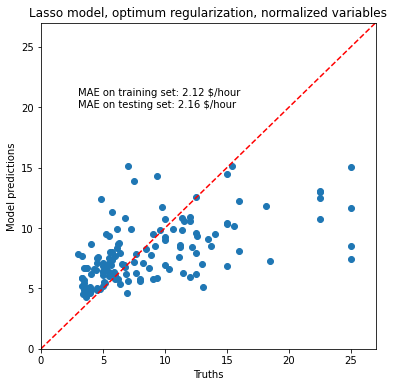

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Lasso model, optimum regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

Pour notre ensemble de données, encore une fois, le modèle n'est pas très prédictif.

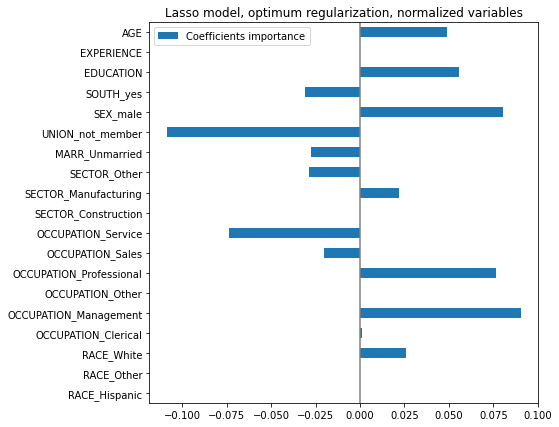

In [41]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Un modèle Lasso identifie la corrélation entre AGE et EXPÉRIENCE et supprime l'un d'eux pour les besoins de la prédiction.

Il est important de garder à l'esprit que les coefficients qui ont été supprimés peuvent toujours être liés au résultat par eux-mêmes : le modèle a choisi de les supprimer car ils n'apportent que peu ou pas d'informations supplémentaires en plus des autres caractéristiques. De plus, cette sélection est instable pour les caractéristiques corrélées et doit être interprétée avec prudence.

En effet, nous pouvons vérifier la variabilité des coefficients à travers les plis.

In [42]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

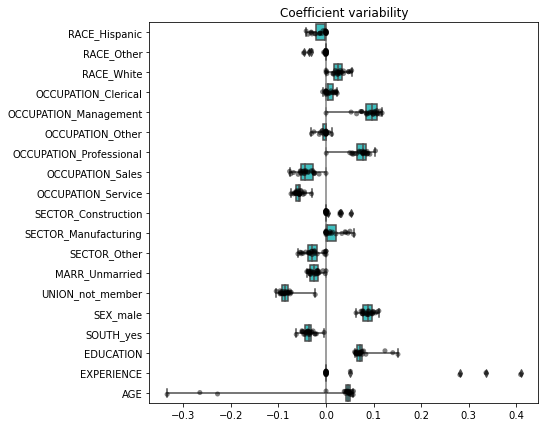

In [43]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

On observe que les coefficients AGE et EXPERIENCE varient beaucoup selon les plis.

## Leçons apprises

* Les coefficients doivent être mis à l'échelle selon la même unité de mesure pour récupérer l'importance des caractéristiques. Les mettre à l'échelle avec l'écart-type de la fonction est un proxy utile.

* Les coefficients dans les modèles linéaires multivariés représentent la dépendance entre une caractéristique donnée et la cible, conditionnelle aux autres caractéristiques.

* Les caractéristiques corrélées induisent des instabilités dans les coefficients des modèles linéaires et leurs effets ne peuvent pas être bien séparés.

* Différents modèles linéaires réagissent différemment à la corrélation des caractéristiques et les coefficients peuvent varier considérablement les uns des autres.

* L'inspection des coefficients à travers les plis d'une boucle de validation croisée donne une idée de leur stabilité.